# Loading Raw Data

In [0]:

spark.sql("USE CATALOG workspace")
spark.sql("USE SCHEMA students_stress")


df_raw = spark.table("student_stress_factors_raw")

df_raw.printSchema()
df_raw.show(6)
df_raw.columns


root
 |-- Kindly Rate your Sleep Quality 😴: long (nullable = true)
 |-- How many times a week do you suffer headaches 🤕?: long (nullable = true)
 |-- How would you rate you academic performance 👩‍🎓?: long (nullable = true)
 |-- how would you rate your study load?: long (nullable = true)
 |-- How many times a week you practice extracurricular activities 🎾?: long (nullable = true)
 |-- How would you rate your stress levels?: long (nullable = true)

+---------------------------------+-------------------------------------------------+--------------------------------------------------+-----------------------------------+-----------------------------------------------------------------+--------------------------------------+
|Kindly Rate your Sleep Quality 😴|How many times a week do you suffer headaches 🤕?|How would you rate you academic performance 👩‍🎓?|how would you rate your study load?|How many times a week you practice extracurricular activities 🎾?|How would you rate your stress levels?

['Kindly Rate your Sleep Quality 😴',
 'How many times a week do you suffer headaches 🤕?',
 'How would you rate you academic performance 👩\u200d🎓?',
 'how would you rate your study load?',
 'How many times a week you practice extracurricular activities 🎾?',
 'How would you rate your stress levels?']

# Cleaning Raw Data
## Renaming thge columns

In [0]:
from pyspark.sql import functions as F

df = df_raw

df = (
    df
    .withColumnRenamed("Kindly Rate your Sleep Quality 😴", "sleep_quality")
    .withColumnRenamed("How many times a week do you suffer headaches 🤕?", "headaches_per_week")
    .withColumnRenamed("How would you rate you academic performance 👩‍🎓?", "academic_performance")
    .withColumnRenamed("how would you rate your study load?", "study_load")
    .withColumnRenamed("How many times a week you practice extracurricular activities 🎾?", "extracurricular_freq")
    .withColumnRenamed("How would you rate your stress levels?", "stress_level")
)

df.printSchema()
df.show(6)


root
 |-- sleep_quality: long (nullable = true)
 |-- headaches_per_week: long (nullable = true)
 |-- academic_performance: long (nullable = true)
 |-- study_load: long (nullable = true)
 |-- extracurricular_freq: long (nullable = true)
 |-- stress_level: long (nullable = true)

+-------------+------------------+--------------------+----------+--------------------+------------+
|sleep_quality|headaches_per_week|academic_performance|study_load|extracurricular_freq|stress_level|
+-------------+------------------+--------------------+----------+--------------------+------------+
|            3|                 1|                   3|         4|                   2|           3|
|            4|                 1|                   2|         3|                   3|           2|
|            2|                 1|                   2|         1|                   4|           4|
|            3|                 2|                   3|         2|                   3|           3|
|            2

# Cleaning Raw Data
## Cast values + clean Data

In [0]:
numeric_cols = [
    "sleep_quality",
    "headaches_per_week",
    "academic_performance",
    "study_load",
    "extracurricular_freq",
    "stress_level"
]

# Cast to integer
for col in numeric_cols:
    df = df.withColumn(col, F.col(col).cast("int"))

# Drop rows with null or invalid values
df = df.dropna(subset=numeric_cols)

df.show(10)
df.printSchema()


+-------------+------------------+--------------------+----------+--------------------+------------+
|sleep_quality|headaches_per_week|academic_performance|study_load|extracurricular_freq|stress_level|
+-------------+------------------+--------------------+----------+--------------------+------------+
|            3|                 1|                   3|         4|                   2|           3|
|            4|                 1|                   2|         3|                   3|           2|
|            2|                 1|                   2|         1|                   4|           4|
|            3|                 2|                   3|         2|                   3|           3|
|            2|                 3|                   1|         5|                   5|           3|
|            3|                 1|                   3|         2|                   1|           1|
|            3|                 5|                   1|         4|                   3|    

# Feature Engineering 
## New Columns: 

### 1.wellbeing_score → combines sleep, extracurricular, low headaches

### 2.academic_stress_index → based on study load + academic performance

### 3.combined_risk_score → predicts high stress conditions

In [0]:
# Wellbeing score (higher = healthier)
df = df.withColumn(
    "wellbeing_score",
    F.round((F.col("sleep_quality") * 2 + F.col("extracurricular_freq") - F.col("headaches_per_week")), 2)
)

# Academic stress index (higher = more academic pressure)
df = df.withColumn(
    "academic_stress_index",
    F.round((F.col("study_load") * 1.5 - F.col("academic_performance")), 2)
)

# Overall risk score (combined)
df = df.withColumn(
    "risk_score",
    F.round(
        (F.col("stress_level") * 2 + F.col("academic_stress_index") - F.col("wellbeing_score")),
        2
    )
)

df.show(10)


+-------------+------------------+--------------------+----------+--------------------+------------+---------------+---------------------+----------+
|sleep_quality|headaches_per_week|academic_performance|study_load|extracurricular_freq|stress_level|wellbeing_score|academic_stress_index|risk_score|
+-------------+------------------+--------------------+----------+--------------------+------------+---------------+---------------------+----------+
|            3|                 1|                   3|         4|                   2|           3|              7|                  3.0|       2.0|
|            4|                 1|                   2|         3|                   3|           2|             10|                  2.5|      -3.5|
|            2|                 1|                   2|         1|                   4|           4|              7|                 -0.5|       0.5|
|            3|                 2|                   3|         2|                   3|           3|

#Saving the cleaned Data



In [0]:
spark.sql("USE CATALOG workspace")
spark.sql("USE SCHEMA students_stress")

df.write.format("delta").mode("overwrite").saveAsTable(
    "workspace.students_stress.student_stress_clean"
)

print("Saved cleaned table as workspace.students_stress.student_stress_clean")


Saved cleaned table as workspace.students_stress.student_stress_clean


# Notebook analysis
## Describing the cleaned table columns

In [0]:
df_clean = spark.table("workspace.students_stress.student_stress_clean")

df_clean.select(
    "sleep_quality", "headaches_per_week",
    "academic_performance", "study_load",
    "extracurricular_freq", "stress_level",
    "wellbeing_score", "academic_stress_index", "risk_score"
).describe().show()


+-------+-----------------+------------------+--------------------+------------------+--------------------+------------------+-----------------+---------------------+--------------------+
|summary|    sleep_quality|headaches_per_week|academic_performance|        study_load|extracurricular_freq|      stress_level|  wellbeing_score|academic_stress_index|          risk_score|
+-------+-----------------+------------------+--------------------+------------------+--------------------+------------------+-----------------+---------------------+--------------------+
|  count|              520|               520|                 520|               520|                 520|               520|              520|                  520|                 520|
|   mean|            3.125|2.1826923076923075|   3.326923076923077|              2.75|  2.6826923076923075|             2.875|             6.75|   0.7980769230769231|-0.20192307692307693|
| stddev|1.099023037868148|1.2474592527309072|  1.0611578699

# Notebook analysis
## Stress level by sleep quality (performing avg(),count()functions)

In [0]:
import pyspark.sql.functions as F

stress_by_sleep = (
    df_clean.groupBy("sleep_quality")
        .agg(
            F.count("*").alias("num_students"),
            F.round(F.avg("stress_level"), 2).alias("avg_stress_level")
        )
        .orderBy("sleep_quality")
)

display(stress_by_sleep)


sleep_quality,num_students,avg_stress_level
1,35,2.14
2,115,2.74
3,185,2.97
4,120,2.75
5,65,3.46


# Notebook analysis
## Stress vs Headaches Frequency

In [0]:
stress_vs_headaches = (
    df_clean.groupBy("headaches_per_week")
        .agg(
            F.count("*").alias("num_students"),
            F.round(F.avg("stress_level"), 2).alias("avg_stress_level"),
            F.round(F.avg("wellbeing_score"), 2).alias("avg_wellbeing_score")
        )
        .orderBy("headaches_per_week")
)

display(stress_vs_headaches)


headaches_per_week,num_students,avg_stress_level,avg_wellbeing_score
1,215,2.86,8.21
2,110,3.36,7.32
3,115,2.52,5.09
4,45,2.78,4.56
5,35,2.71,4.29


# Notebook analysis
## Extracurricular Activity vs Stress

In [0]:
activity_vs_stress = (
    df_clean.groupBy("extracurricular_freq")
        .agg(
            F.count("*").alias("num_students"),
            F.round(F.avg("stress_level"), 2).alias("avg_stress_level")
        )
        .orderBy("extracurricular_freq")
)

display(activity_vs_stress)


extracurricular_freq,num_students,avg_stress_level
1,160,2.72
2,95,2.95
3,110,2.95
4,60,3.0
5,95,2.89


# Notebook analysis
## Correlation Matrix


In [0]:
num_cols = [
    "sleep_quality", "headaches_per_week", "academic_performance",
    "study_load", "extracurricular_freq", "stress_level",
    "wellbeing_score", "academic_stress_index", "risk_score"
]

import pandas as pd

corr_data = df_clean.select(num_cols).toPandas().corr()
corr_data


,sleep_quality,headaches_per_week,academic_performance,study_load,extracurricular_freq,stress_level,wellbeing_score,academic_stress_index,risk_score
sleep_quality,1.000000,-0.058851,0.254016,0.065470,0.000745,0.165431,0.751391,-0.060610,-0.406854
headaches_per_week,-0.058851,1.000000,-0.205316,-0.007034,-0.073362,-0.071806,-0.490901,0.091467,0.310240
academic_performance,0.254016,-0.205316,1.000000,0.095921,0.153015,0.055161,0.343700,-0.388411,-0.364327
study_load,0.065470,-0.007034,0.095921,1.000000,0.175407,0.391622,0.135780,0.879980,0.542234
extracurricular_freq,0.000745,-0.073362,0.153015,0.175407,1.000000,0.052463,0.517082,0.089364,-0.254058
stress_level,0.165431,-0.071806,0.055161,0.391622,0.052463,1.000000,0.175356,0.336222,0.609412
wellbeing_score,0.751391,-0.490901,0.343700,0.135780,0.517082,0.175356,1.000000,-0.038318,-0.547187
academic_stress_index,-0.060610,0.091467,-0.388411,0.879980,0.089364,0.336222,-0.038318,1.000000,0.675837
risk_score,-0.406854,0.310240,-0.364327,0.542234,-0.254058,0.609412,-0.547187,0.675837,1.000000


<Axes: >

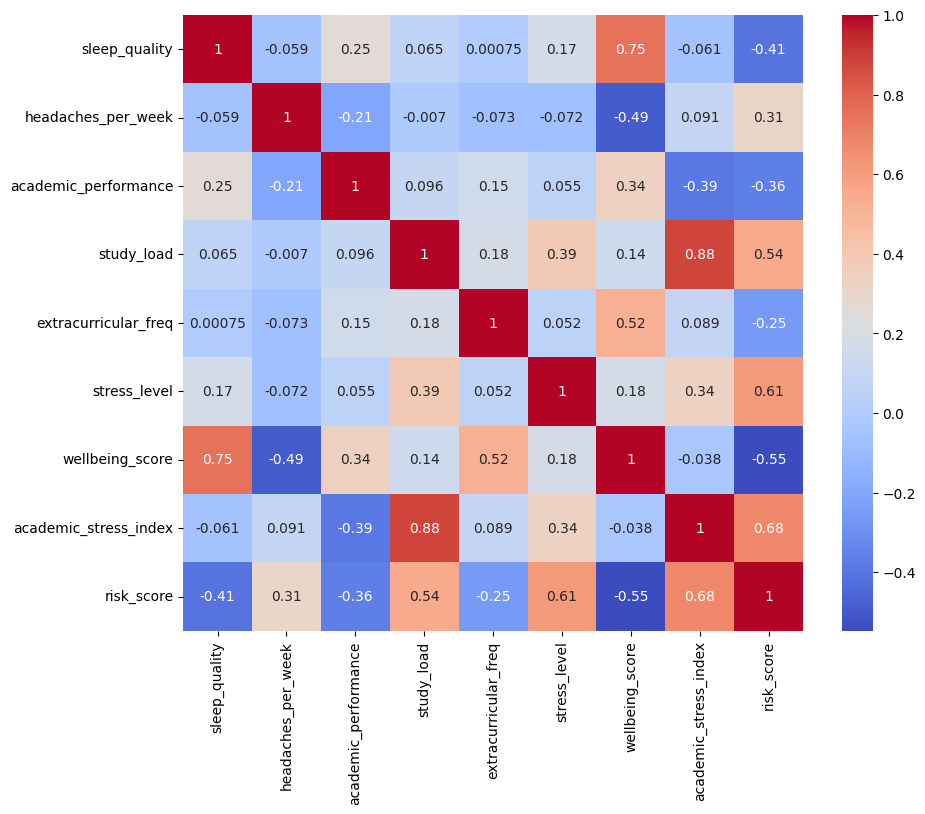

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(corr_data, annot=True, cmap="coolwarm")
